## Relax Inc Take Home Challenge

## 1. Load the Two Datasets

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


Looks like nothing is missing. Lets look at the other dataframe.

In [5]:
df1= pd.read_csv('takehome_users.csv', encoding='ISO-8859-1')

In [6]:
df1.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


Some missing values in the "last session creation time" and "invited by user id" columns.

## 2.  Data Wrangling

### 2.1 Missing Data

Lets fill in the missing data for these two particular columns. First lets start with the "last session creation time" column. We will turn it into a date time of seconds then fill the null values with the creation time as they probably only used it once when they created the account.

In [8]:
df1['last_session_creation_time'] = pd.to_datetime(df1['last_session_creation_time'], unit='s')
df1['last_session_creation_time'] = df1['last_session_creation_time'].fillna(df1['creation_time'])

Now lets fill the null values as 0 for "invited by user id" column.

In [9]:
df1['invited_by_user_id'] = df1['invited_by_user_id'].fillna(0)

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  object        
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  12000 non-null  datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          12000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 937.6+ KB


### 2.2 Convert Time Columns to Dateframe

In [11]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [12]:
df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


Looks good. Now we are ready to do data EDA and create a model for our main objective of identify which factors predict future user
adoption.

## 3. EDA

### 3.1 Explore Columns

In [13]:
df['user_id'].nunique()

8823

In [14]:
len(df)

207917

In [15]:
len(df)/df['user_id'].nunique()

23.565340587101893

Here we have 8,823 unique users and 207,917 logins. For an average of 23.565 logins per user.

In [16]:
df['visited'].value_counts().head()

visited
1    207917
Name: count, dtype: int64

We can drop the visited column since they are all the same.

In [17]:
df= df.drop(['visited'], axis=1)

In [18]:
df1['invited_by_user_id'].value_counts().head()

invited_by_user_id
0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
Name: count, dtype: int64

In [19]:
df1['creation_source'].value_counts().head()

creation_source
ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: count, dtype: int64

In [20]:
df1['org_id'].value_counts().head()

org_id
0    319
1    233
2    201
3    168
4    159
Name: count, dtype: int64

In [21]:
df1['opted_in_to_mailing_list'].value_counts().head()

opted_in_to_mailing_list
0    9006
1    2994
Name: count, dtype: int64

Lets see if a user logged in on three different days in a seven day timeframe.

In [22]:
def login_user(df, days=7, separate_login=3):
    df['date'] = df['time_stamp'].dt.date
    days_after_three_logins = df['date'].diff(periods=separate_login-1)
    df = df.drop_duplicates(subset='date').sort_values('date')
    return any(days_after_three_logins <= timedelta(days=days))

In [23]:
adopted_user = df.groupby('user_id').apply(login_user)
df1['adopted_user'] = adopted_user

In [24]:
df1['adopted_user'].value_counts().head()

adopted_user
False    7166
True     1656
Name: count, dtype: int64

Here we had 1656 adopted users that logged in on three separate days in a seven day timeframe out of 8823 unique user ids. 18.76% were adopted users. 

In [25]:
df1['adopted_user'].value_counts().head()

adopted_user
False    7166
True     1656
Name: count, dtype: int64

### 3.2 Visualizations

<Axes: xlabel='count', ylabel='creation_source'>

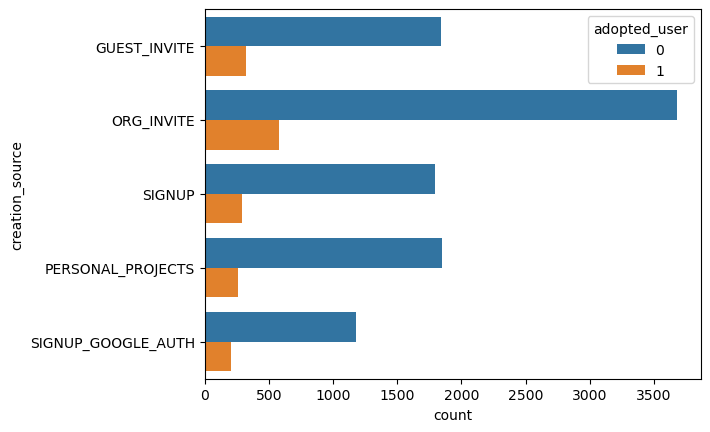

In [27]:
df1["adopted_user"]= df1["adopted_user"].fillna(0).astype(str)
sns.countplot(y =df1['creation_source'], hue = df1['adopted_user'], data = df)

The accounts that were created as a full member were more inclined to to be an adopted user than any other type that was created.

<Axes: xlabel='enabled_for_marketing_drip', ylabel='count'>

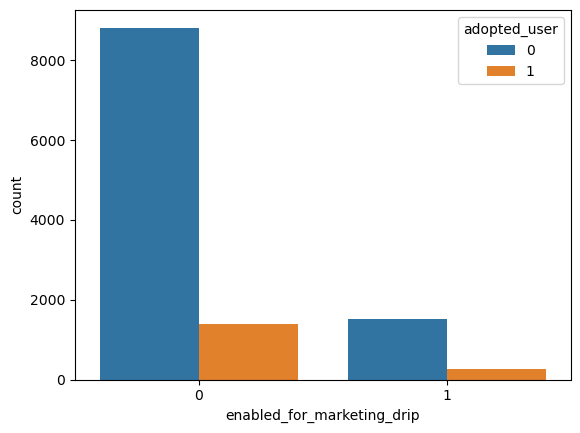

In [28]:
sns.countplot(x =df1['enabled_for_marketing_drip'], hue = df1['adopted_user'], data = df)

Many customers that were not adopted users also did not opted into the marketing drip campaign.

<Axes: xlabel='opted_in_to_mailing_list', ylabel='count'>

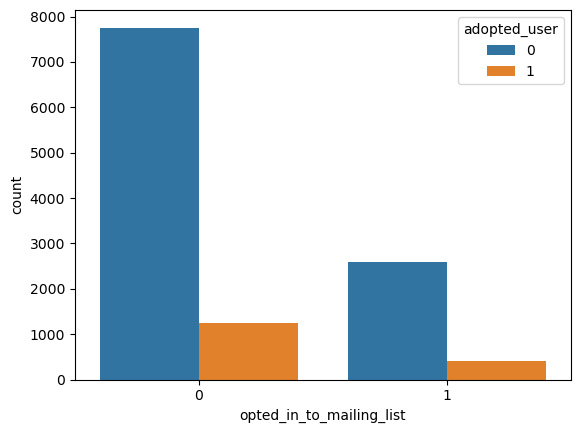

In [29]:
sns.countplot(x =df1['opted_in_to_mailing_list'], hue = df1['adopted_user'], data = df)

Also here non-adopted users were inclined to not opt into the mailing list. This would make sense as some customers are not that interested in their product offerings. More adopted users did not opt into the mailing list than did.

The highest positive correlation was "enabled for marketing drip" and "opted into mailing list" at .48.

## 4. Predicting Adopted Users Model

### 4.1 Get Dummies for Creation Source Column

In [35]:
source = pd.get_dummies(combined['creation_source'])
relax_data = pd.concat([combined, source], axis=1).drop('creation_source', axis=1)

In [36]:
relax_data.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,time_stamp,user_id,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,2014-04-22 03:53:30,1,0,11,10803.0,0,2014-04-22 03:53:30,1,True,False,False,False,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,2014-03-31 03:45:04,0,0,1,316.0,0,2013-11-15 03:45:04,2,False,True,False,False,False
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,2013-03-19 23:14:52,0,0,94,1525.0,1,2013-11-29 03:45:04,2,False,True,False,False,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,2013-05-22 08:09:28,0,0,1,5151.0,0,2013-12-09 03:45:04,2,True,False,False,False,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,2013-01-22 10:14:20,0,0,193,5240.0,0,2013-12-25 03:45:04,2,True,False,False,False,False


In [37]:
'object_id','user_id','org_id',

('object_id', 'user_id', 'org_id')

The data looks ready to start our train test split of the relax data to predict if they are an adopted user or not.

In [38]:
y = relax_data['adopted_user']
X = relax_data[['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id', 
               'GUEST_INVITE', 'ORG_INVITE', 'PERSONAL_PROJECTS', 
              'SIGNUP', 'SIGNUP_GOOGLE_AUTH']]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify= y, random_state=42)

### 4.2 Random Forest Classifier with Grid Search Cross Validation

In [40]:
rf = RandomForestClassifier(random_state=42, min_samples_split=3, class_weight='balanced')
params = {'n_estimators': [10, 50, 100, 200]}  
GridSearchCV = GridSearchCV(rf, params)
GridSearchCV.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              min_samples_split=3,
                                              random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 200]})

In [41]:
rf_best_cv_results = cross_validate(GridSearchCV.best_estimator_, X_train, y_train, cv=10)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.70833333, 0.6047619 , 0.62619048, 0.6047619 , 0.61785714,
       0.72619048, 0.70952381, 0.69642857, 0.64761905, 0.71428571])

In [42]:
np.mean(rf_best_scores), np.std(rf_best_scores)

(0.6655952380952381, 0.047228907756702965)

An average of .8501 from the Grid Search CV is solid.

### 4.3 Feature Importances

In [43]:
rfc = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200)

In [44]:
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [46]:
y_pred= rfc.predict(X_test)

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3103
           1       0.15      0.25      0.19       497

    accuracy                           0.71      3600
   macro avg       0.51      0.52      0.51      3600
weighted avg       0.77      0.71      0.73      3600



In [48]:
y_test.value_counts()

adopted_user
0    3103
1     497
Name: count, dtype: int64

In [49]:
features = pd.Series(rfc.feature_importances_, index=X.columns)
features = features.sort_values(ascending=False)
features

invited_by_user_id            0.971484
opted_in_to_mailing_list      0.008761
enabled_for_marketing_drip    0.008322
GUEST_INVITE                  0.003809
ORG_INVITE                    0.002611
PERSONAL_PROJECTS             0.002321
SIGNUP_GOOGLE_AUTH            0.001449
SIGNUP                        0.001242
dtype: float64

### 4.4 Classification Report

In [50]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3103
           1       0.15      0.25      0.19       497

    accuracy                           0.71      3600
   macro avg       0.51      0.52      0.51      3600
weighted avg       0.77      0.71      0.73      3600



In [52]:
print('Accuracy Score is:', accuracy_score(y_test, y_pred))

Accuracy Score is: 0.7052777777777778


### 4.5 Confusion Matrix

In [53]:
print(confusion_matrix(y_test, y_pred))

[[2413  690]
 [ 371  126]]
